In [1]:
def parse_params_entry(row, columns):

    """
    zmienna columns dostaje kolejne nazwy a zwracana jest lista z wartościami
    """

    entry = []
    unordered = {}
    for param in row.split("<br>"):
        
        key_value = param.split("<=>")

        # pomija parametry bez wartości
        no_value = len(key_value) == 1
        if (no_value):
            continue

        key = key_value[0]

        # niektóre zmienne kończą się na _types i mają wtedy wiele możliwości które się dodatkowo łączą
        # tutaj są zamieniane na zmienne binarne
        if (key.endswith("types")):
            
            if key_value[1].strip() == "" or key_value[1].strip() == "0":
                continue

            for value in key_value[1].split("<->"):

                real_key = key + "_" + value
                if real_key not in columns:
                    columns.append(real_key)
                unordered[real_key] = True
            continue
        
        # dodaje nazwę parametru do nagłówka
        value = key_value[1]
        if key not in columns:
            columns.append(key)

        unordered[key] = value

    for key in columns:
        entry.append(unordered[key] if key in unordered else None)    

    return entry

In [15]:
def read_data(path, param_name = "params", nchunks = None, drop = [], chunksize = 10000):

    """
    zbiera parametry w formacie <key><=>value<->value<->value<br>key><=>value<->... z DataFrame,
    >>> parse_params(df)
    id    price[currency]       m rooms_num     market  ... fence_types heating_types access_types vicinity_types is_bungalow
    325017             PLN   72.14         4  secondary  ...        None          None         None           None        None
    """

    import pandas

    param_cols = []
    csv_entries = []

    print('Ładowanie wierszy:')
    empty = pandas.read_csv(path, nrows=0).columns.drop(drop)
    iterator = pandas.read_csv(path, chunksize=chunksize)
    for (k, chunk) in enumerate(iterator):

        if (nchunks is not None and k >= nchunks):
            break      
        for (i, row) in chunk.drop(columns=drop).iterrows():
            
            entry = parse_params_entry(row[param_name], param_cols)
            csv_entries.append([*row.drop(param_name), *entry])

        print(f'{(k+1)*10}k', end='\n' if ((k+1)%10 == 0) else ' ')
    
    from pandas import DataFrame

    return DataFrame(csv_entries, columns=[*empty.drop(param_name), *param_cols])

In [16]:
df = read_data('train.csv', drop = ['description', 'title'])
df.set_index('id', inplace=True)

Ładowanie wierszy:
10k 20k 30k 40k 50k 60k 70k 80k 90k 100k
110k 120k 130k 140k 150k 160k 170k 180k 190k 200k
210k 220k 230k 240k 250k 260k 270k 280k 290k 300k
310k 320k 330k 340k 350k 360k 370k 380k 390k 400k
410k 420k 430k 440k 450k 460k 470k 480k 490k 500k
510k 520k 530k 540k 550k 560k 570k 580k 590k 600k
610k 620k 630k 640k 650k 660k 670k 680k 690k 700k
710k 720k 730k 740k 750k 760k 770k 780k 790k 800k
810k 820k 830k 840k 

In [17]:
def get_lon_lat_inplace(df, type = 'city', path = 'cities.csv'):
    
    import pandas
    
    cities = pandas.read_csv(path)[['id','lon','lat']]
    cities.rename(columns= {"id" : f'{type}_id', 'lon': f'{type}_lon', 'lat': f'{type}_lat'}, inplace=True)
    
    df = pandas.merge(df, cities, on = f'{type}_id', how='left')

get_lon_lat_inplace(df, 'city', 'cities.csv')
get_lon_lat_inplace(df, 'district', 'districts.csv')

## Braki

### Wartości prawie nieobecne

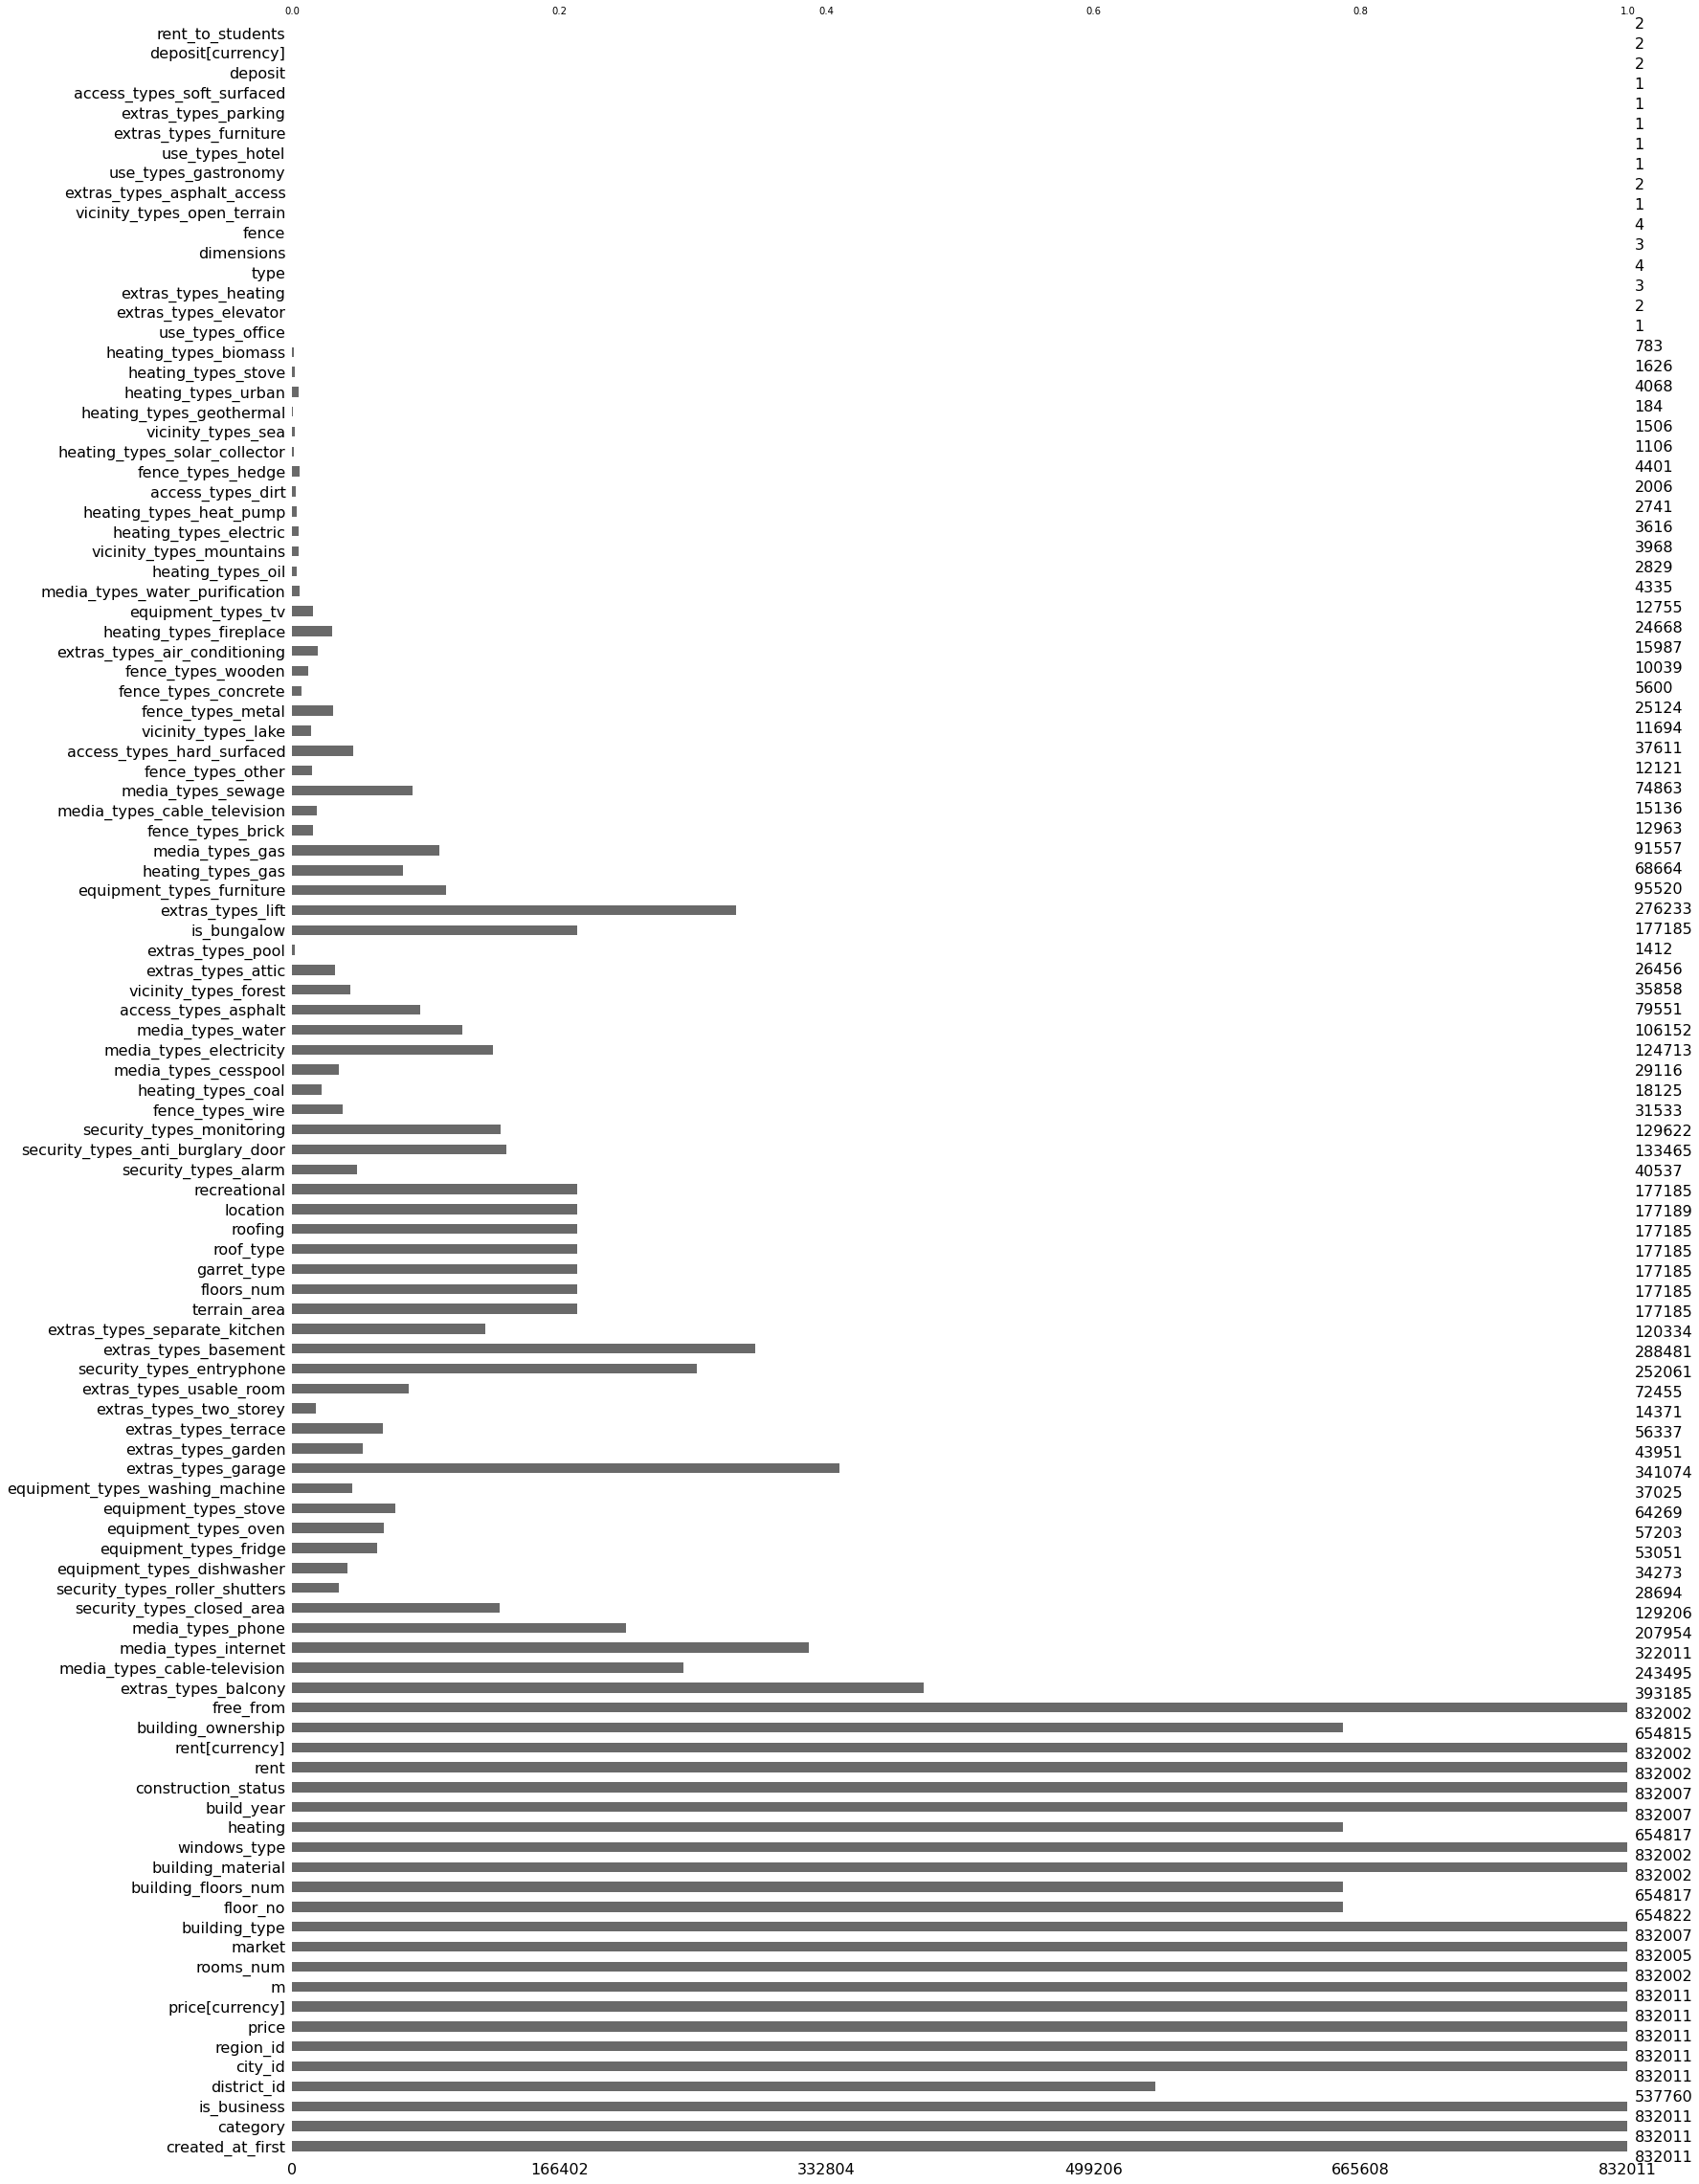

In [18]:
from missingno import bar as NA_bar
NA_bar(df);

In [19]:
def drop_unique_not_NA(df, thresh):

  initial_columns = df.shape[1]
  df.dropna(thresh=thresh, axis=1, inplace=True)
  dropped_columns = initial_columns - df.shape[1]
  print("Liczba wyrzuconych kolumn:", dropped_columns)

drop_unique_not_NA(df,2)

Liczba wyrzuconych kolumn: 7


In [20]:
df.drop(columns=['city_id', 'region_id', 'district_id'], inplace=True)

In [22]:
drop_unique_not_NA(df, 10)

Liczba wyrzuconych kolumn: 9


### Kategorie

In [25]:
def handle_heating(df):

  df['heating_gas'] =  ((df['heating'] == 'gas') | df['heating_types_gas']).astype(int)
  df.drop(columns=['heating_types_gas'], inplace=True)

  df['heating_urban'] =  ((df['heating'] == 'urban') | df['heating_types_urban']).astype(int)
  df.drop(columns=['heating_types_urban'], inplace=True)

  other_heating_values = ['other', 'electric', 'boiler_room', 'tiled_stove']
  other_heating_cols = [
    'heating_types_fireplace', 
    'heating_types_electric',
    'heating_types_coal', 
    'heating_types_oil', 
    'heating_types_heat_pump',
    'heating_types_stove',
    'heating_types_solar_collector',
    'heating_types_biomass',
    'heating_types_geothermal'
  ]

  df['heating_other'] =  (df['heating'].isin(other_heating_values) | df[other_heating_cols].any(axis = 1)).astype(int)
  df.drop(columns=other_heating_cols, inplace=True)

handle_heating(df)

In [26]:
df['fence'] = df[df.filter(like='fence').columns].any(axis = 1).astype(int)
df.drop(columns=df.drop('fence', axis=1).filter(like='fence'), inplace=True)

In [27]:
df['furniture'] = df['equipment_types_furniture'].fillna(False).astype(int)
df['equipment'] = df[[
    'equipment_types_stove',
    'equipment_types_oven',
    'equipment_types_fridge',
    'equipment_types_washing_machine',
    'equipment_types_dishwasher',
    'equipment_types_tv',
]].any(axis=1).astype(int)
df.drop(columns=df.drop('equipment', axis=1).filter(like='equipment'), inplace=True)

In [28]:
df['connectivity'] = df[[
  'media_types_internet', 'media_types_cable-television', 'media_types_cable_television', 'media_types_phone'
]].any(axis=1).astype(int)
df['media'] = df[[
  'media_types_water', 'media_types_electricity', 'media_types_gas', 'media_types_sewage', 'media_types_cesspool', 'media_types_water_purification'
]].any(axis=1).astype(int)

df.drop(columns=df.drop('media', axis=1).filter(like='media'), inplace=True)

In [29]:
df['entryphone'] = df['security_types_entryphone'].fillna(False).astype(int)
df['security'] = df[['security_types_anti_burglary_door', 'security_types_monitoring', 'security_types_alarm']].any(axis=1).astype(int)
df['closed'] = df['security_types_closed_area'].fillna(False).astype(int)
df['rollers'] = df['security_types_roller_shutters'].fillna(False).astype(int)

df.drop(columns=df.drop('security', axis=1).filter(like='security'), inplace=True)

In [30]:
df['balcony'] = df[['extras_types_balcony', 'extras_types_terrace']].any(axis=1).astype(int)
df['garden'] = df[['extras_types_garden']].any(axis=1).astype(int)
df['pool'] = df[['extras_types_pool']].any(axis=1).astype(int)
df['lift'] = df[['extras_types_lift']].any(axis=1).astype(int)
df['space'] = df[['extras_types_basement','extras_types_attic', 'extras_types_usable_room']].any(axis=1).astype(int)

df.drop(columns=df.filter(like='extras').columns, inplace=True)

In [31]:
df['water'] = df[['vicinity_types_sea', 'vicinity_types_lake', 'vicinity_types_mountains']].any(axis=1).astype(int)
# rzeki zaczynają się też w górach dlatego wodaa!!
df['forest'] = df['vicinity_types_forest'].fillna(False).astype(int)

df.drop(columns=df.filter(like='vicinity').columns, inplace=True)

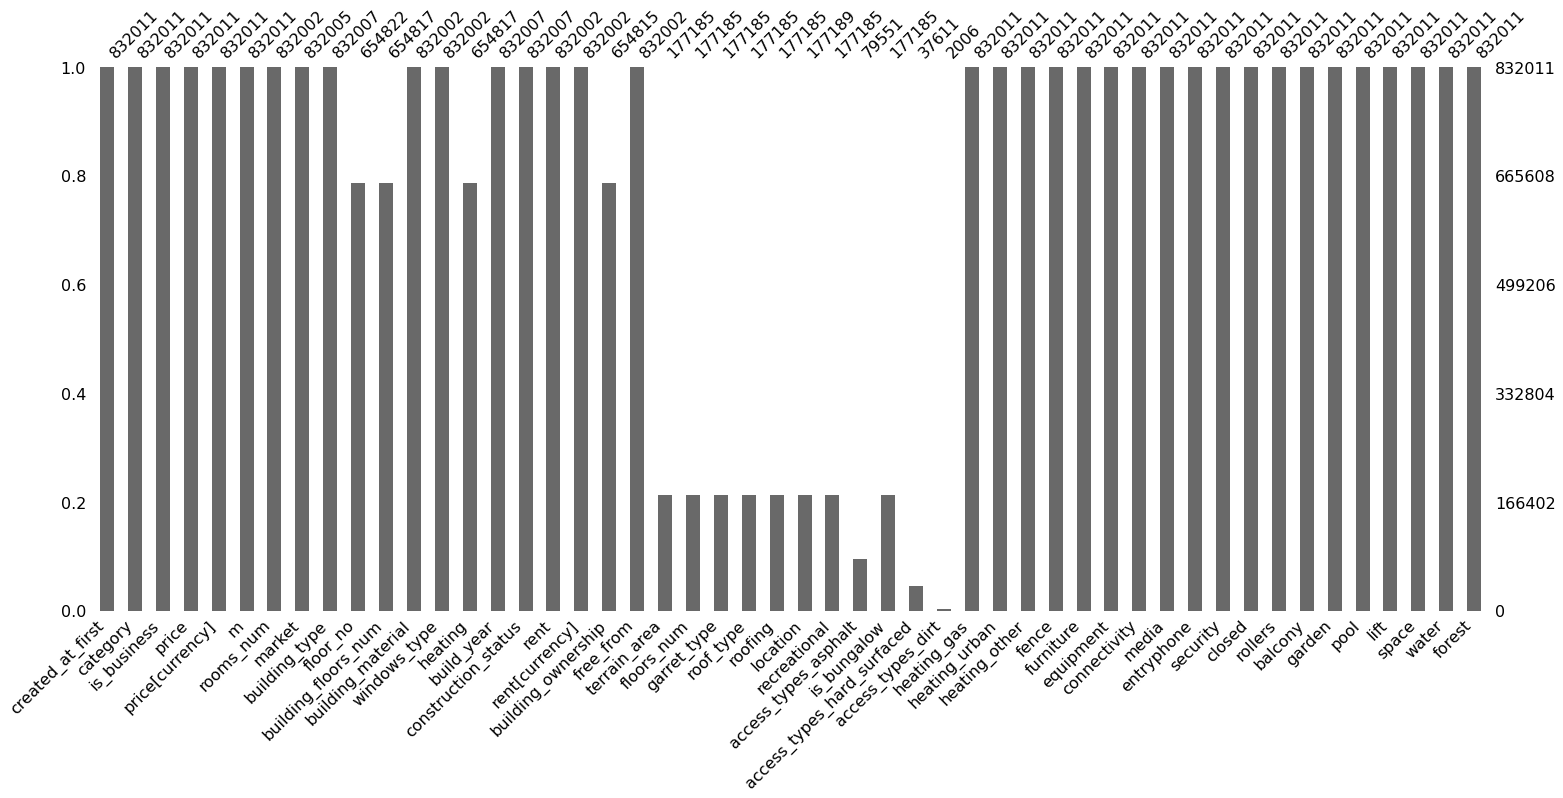

In [32]:
from missingno import bar as NA_bar
NA_bar(df);

In [50]:
from pandas import get_dummies

df.drop(columns=[
    'price[currency]', 'rent[currency]', # nieistotne, (prawie) wszystko to PLN 
    'building_ownership', #????
    'garret_type', #??
    'is_bungalow', # ??
    'roofing', 'location','roof_type', 'recreational', # za dużo NA
    'access_types_asphalt', 'access_types_hard_surfaced', 'access_types_dirt' # przy tylu NA to pomijalne
], inplace=True)
df = get_dummies(df, columns=['rooms_num', 'market', 'category', 'building_type', 'floor_no', 'building_material', 'windows_type', 'construction_status', 'floors_num'])

KeyError: "['price[currency]', 'rent[currency]', 'building_ownership', 'garret_type', 'is_bungalow', 'roofing', 'location', 'roof_type', 'recreational', 'access_types_asphalt', 'access_types_hard_surfaced', 'access_types_dirt'] not found in axis"

In [55]:
from pandas import to_datetime
df['free_from'] = to_datetime(df['free_from'])

In [56]:
from pandas import to_datetime
df['created_at_first'] = to_datetime(df['created_at_first'])

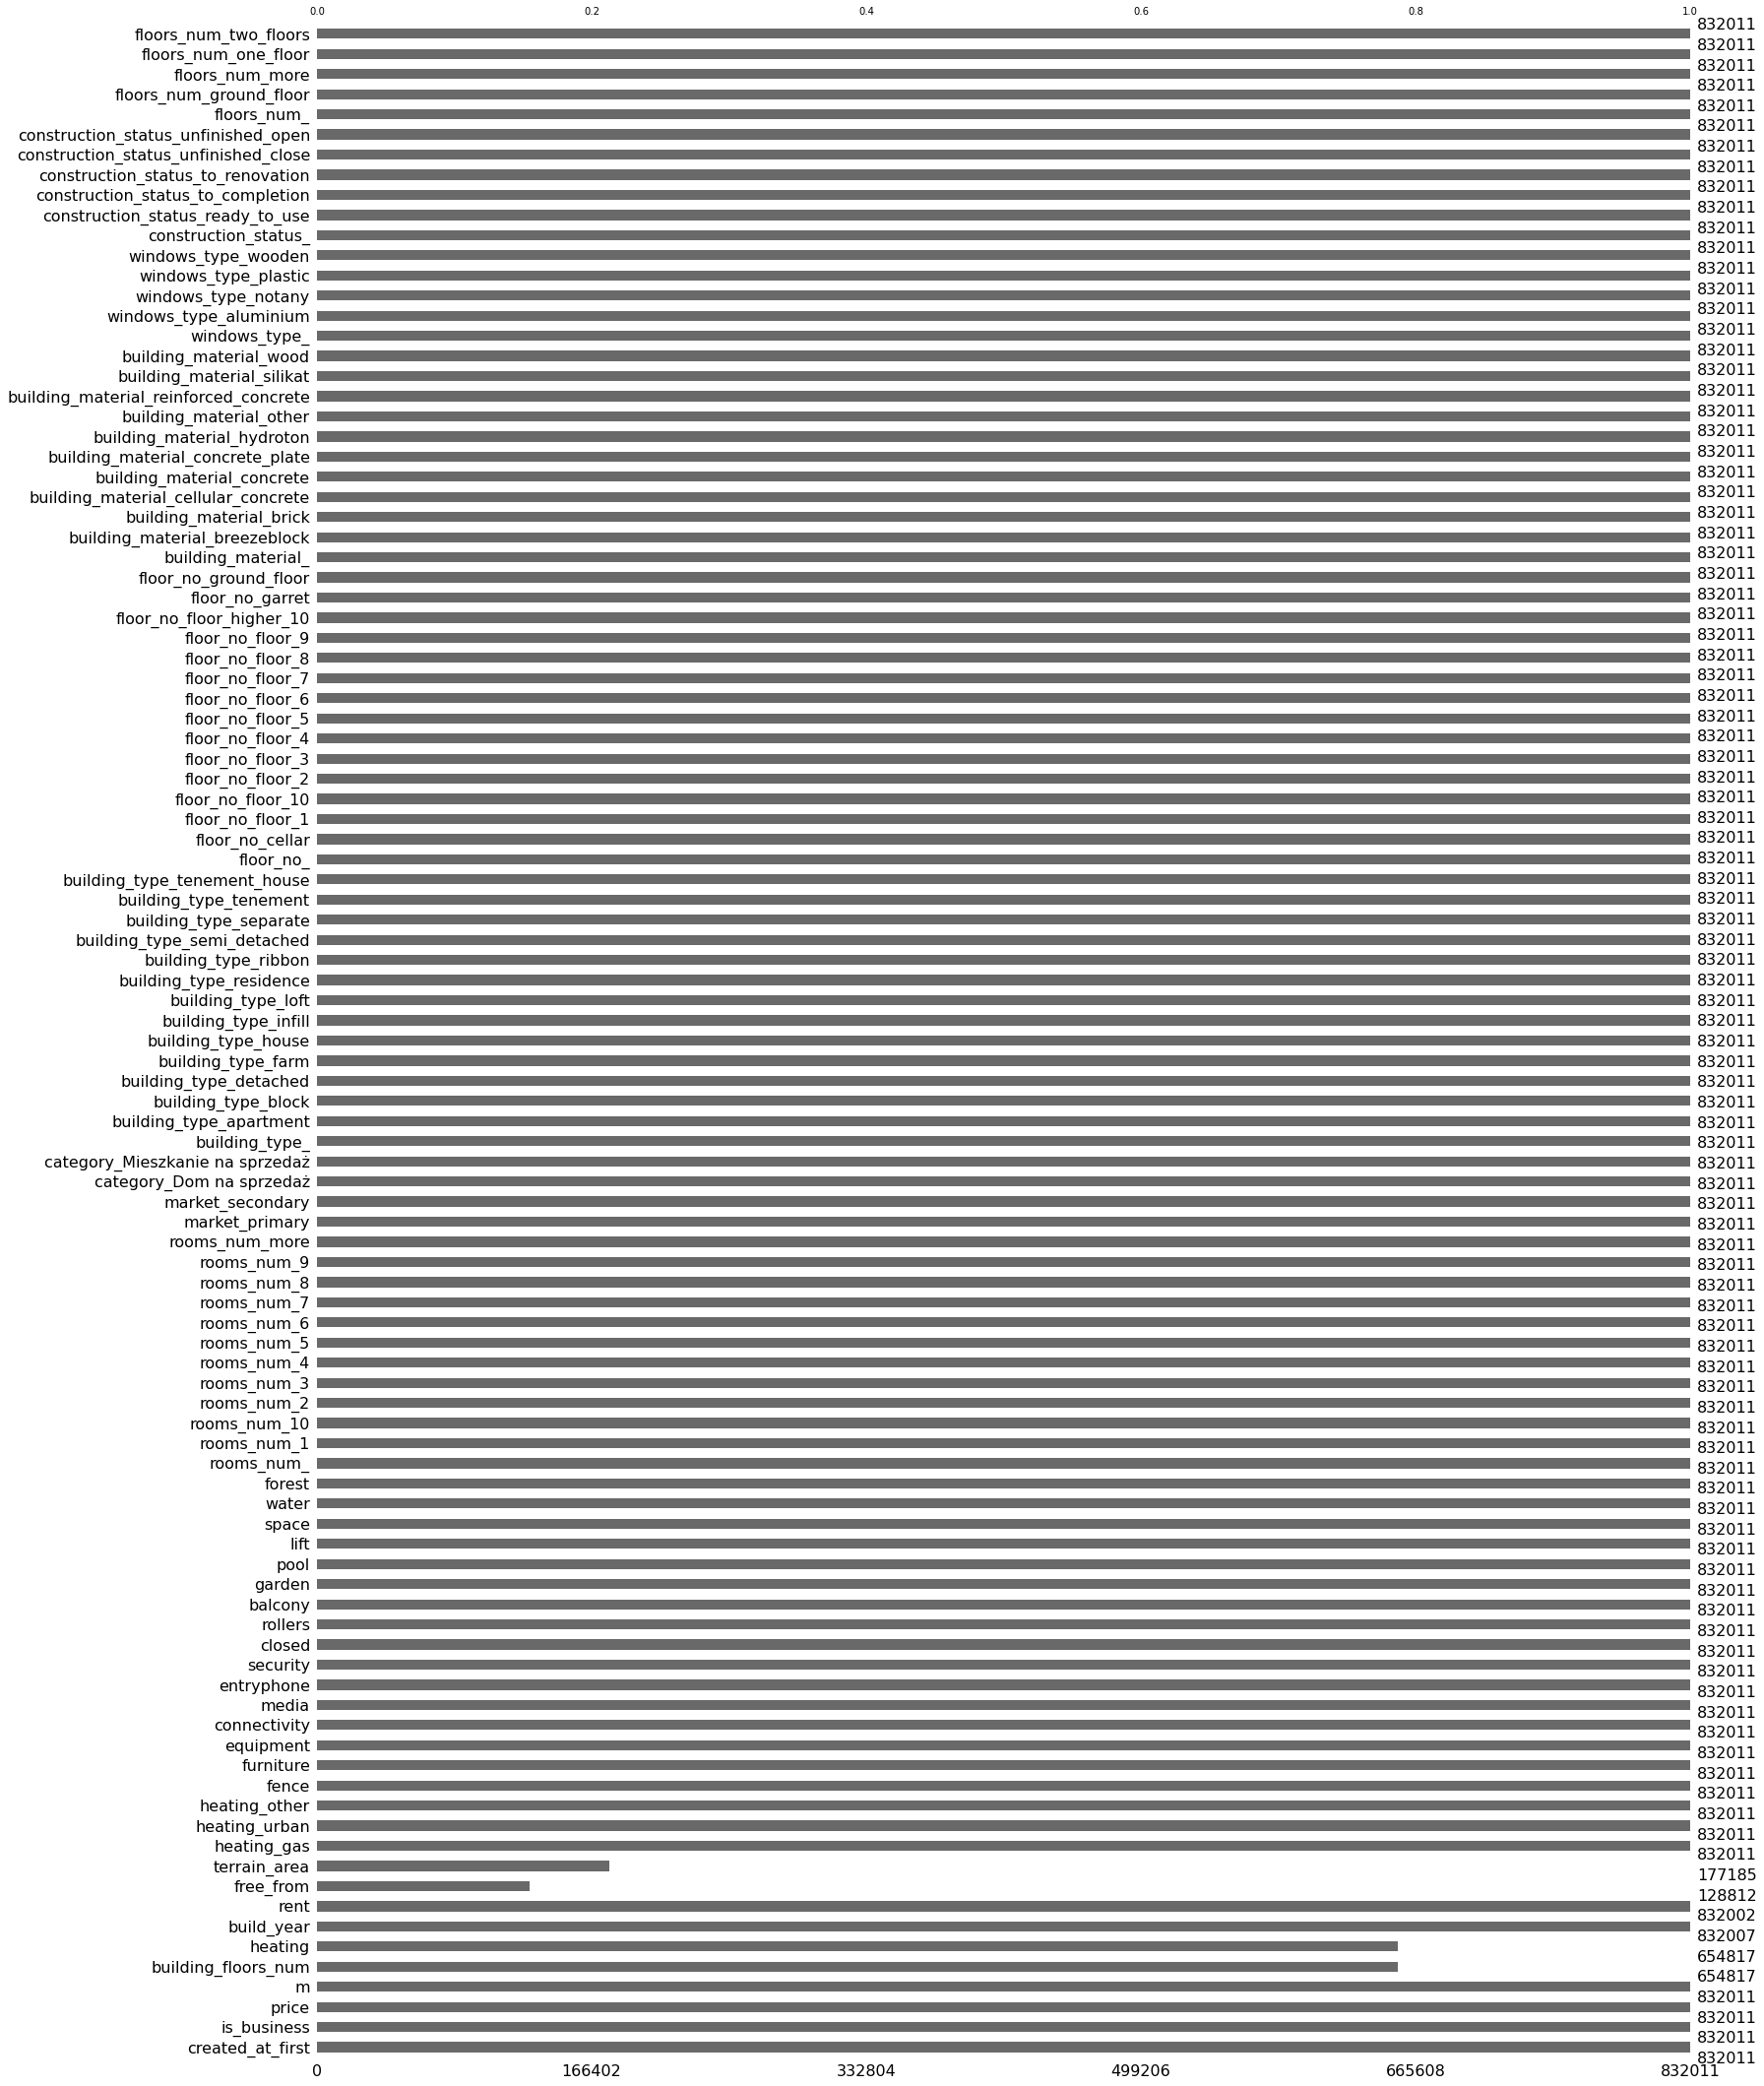

In [59]:
from missingno import bar as NA_bar
NA_bar(df);

In [60]:
df.to_csv('dataset.csv')